In [26]:
import pandas as pd
import numpy as np
import rasterio
import math
import geopandas as gpd
from shapely.geometry import Point
from fiona import Env
import matplotlib.pyplot as plt


In [27]:
# Function to convert latitude and longitude to Bing Maps Quadkey
def lat_lon_to_quadkey(lat, lon, level):
    tile_size = 256

    # Clip latitude and longitude to max values
    lat = max(min(lat, 85.0511287798), -85.0511287798)
    lon = max(min(lon, 180), -180)

    # Convert latitude and longitude to pixel coordinates in a level zoom of the Earth
    x = (lon + 180) / 360
    sin_lat = math.sin(lat * math.pi / 180)
    y = 0.5 - math.log((1 + sin_lat) / (1 - sin_lat)) / (4 * math.pi)

    # Convert Earth coordinates to pixel coordinates
    map_size = tile_size << level
    pixel_x = int(clip(x * map_size + 0.5, 0, map_size - 1))
    pixel_y = int(clip(y * map_size + 0.5, 0, map_size - 1))

    # Convert pixel coordinates to tile coordinates
    tile_x = int(math.floor(pixel_x / tile_size))
    tile_y = int(math.floor(pixel_y / tile_size))

    # Convert tile coordinates to a quadkey
    quadkey = ""
    for i in range(level, 0, -1):
        digit = 0
        mask = 1 << (i - 1)
        if (tile_x & mask) != 0:
            digit += 1
        if (tile_y & mask) != 0:
            digit += 2
        quadkey += str(digit)

    return quadkey

# Function to clip a number to the specified minimum and maximum values
def clip(n, min_value, max_value):
    return min(max(n, min_value), max_value)

# Test the function with an example coordinate
test_quadkey = lat_lon_to_quadkey(45.0, -122.0, 14)
test_quadkey


'02123201001313'

In [28]:

# Load the raster data
with rasterio.open('/Users/kismatkhatri/Downloads/pak_pd_2020_1km.tif') as src:
    pop_data = src.read(1)  # Read the first band
    # Create a mask for valid data (assuming no data values are represented as such)
    mask = pop_data > 0  # Replace with the appropriate condition for valid data
    rows, cols = np.where(mask)
    coords = [src.xy(row, col) for row, col in zip(rows, cols)]  # Convert indices to coordinates
    
    # Convert the coordinates to quadkeys
    quadkeys = [lat_lon_to_quadkey(lat, lon, 14) for lon, lat in coords]
    population = pop_data[mask]  # Extract population values for valid data points
    
    # Create a DataFrame from the quadkeys and population
    pop_quadkey_df = pd.DataFrame({'quadkey': quadkeys, 'population': population})

# Aggregate the population by quadkeys to get the sum of the population per level 14 tile
pop_quadkey_agg_df = pop_quadkey_df.groupby('quadkey')['population'].sum().reset_index()

# Load RWI data and add quadkeys
rwi_df = pd.read_csv('/Users/kismatkhatri/Documents/Capstone project/RWI.csv')
rwi_df['quadkey'] = rwi_df.apply(lambda row: lat_lon_to_quadkey(row['latitude'], row['longitude'], 14), axis=1)

# Join the aggregated population data with the RWI data based on the quadkey
rwi_pop_joined_df = pd.merge(rwi_df, pop_quadkey_agg_df, on='quadkey', how='left')

# Check for any mismatched quadkeys
unmatched_quadkeys = rwi_pop_joined_df[rwi_pop_joined_df['population'].isnull()]['quadkey'].unique()
if len(unmatched_quadkeys) > 0:
    print(f"Warning: There are {len(unmatched_quadkeys)} quadkeys without matching population data.")

# Save the joined DataFrame to a new CSV file
rwi_pop_joined_df.to_csv('/Users/kismatkhatri/Documents/Capstone project/joined_RWI_population.csv', index=False)

# Check the first few rows to ensure the population has been joined correctly
print(rwi_pop_joined_df.head())


    latitude  longitude    rwi  error         quadkey   population
0  33.897776  70.037842 -0.074  0.624  12310221130231  3119.037109
1  31.118794  66.807861 -0.569  0.368  12303111302200  1192.453247
2  32.648625  73.245850 -0.193  0.498  12310322022121  4926.342285
3  35.182788  72.894287 -0.178  0.355  12310213112323  1739.792480
4  25.948166  69.268799 -0.530  0.450  12312201232000  1315.402466


In [29]:
Pslm_data = pd.read_stata('/Users/kismatkhatri/Documents/Capstone project/310_PSLM201920_Rescaledbyhhsize_160654obs.dta')

In [30]:
variables_list1 = [
    "W_dkw_inspiped",
    "W_dkw_inshandpump",
    "W_dkw_insmotorpump",
    "W_dkw_insclosedwell",
    "W_dkw_insopenwell",
    "W_dkw_insprotsprng",
    "W_dkw_insunprsprng",
    "W_dkw_outpiped",
    "W_dkw_outhandpump",
    "W_dkw_outmotorpump",
    "W_dkw_outclosedwell",
    "W_dkw_outopenwell",
    "W_dkw_outprotsprng",
    "W_dkw_outunprsprng",
    "W_dkw_pond",
    "W_dkw_bottwater",
    "W_dkw_tanker",
    "W_dkw_filtration",
    "W_dkw_other",
    "W_toilet_notoilet",
    "W_toilet_flushpub",
    "W_toilet_flushtank",
    "W_toilet_flushpit",
    "W_toilet_flushopen",
    "W_toilet_raiselat",
    "W_toilet_pitlat",
    "W_toilet_other",
    "W_toiletshared",
    "W_toiletprivate",
    "H_cooking_firewood",
    "H_cooking_gas",
    "H_cooking_lpg",
    "H_cooking_dung",
    "H_cooking_crop",
    "H_cooking_other",
    "H_floor_earth",
    "H_floor_ceramic",
    "H_floor_cement",
    "H_floor_bricks",
    "H_floor_other",
    "H_roof_rccrbc",
    "H_roof_wood",
    "H_roof_sheet",
    "H_roof_grader",
    "H_roof_other",
    "H_walls_burntbricks",
    "H_walls_mudbricks",
    "H_walls_wood",
    "H_walls_stones",
    "H_walls_other",
    "D_iradio",
    "D_itelevsion",
    "D_ilcdled",
    "D_irefrigerator",
    "D_ifreezer",
    "D_iwashing",
    "D_idryer",
    "D_iairconditioning",
    "D_iaircooler",
    "D_ifan",
    "D_istove",
    "D_icookingrange",
    "D_imicrowave",
    "D_isewingmachine",
    "D_iknitting",
    "D_iiron",
    "D_iwaterfilter",
    "D_idonkeypump",
    "D_iturbine",
    "D_ichair",
    "D_itable",
    "D_iups",
    "D_igenerator",
    "D_isolarpanel",
    "D_iheater",
    "D_igeaser",
    "D_ibicycle",
    "D_imotorcyclescotter",
    "D_irichshaw",
    "D_icar",
    "D_ivantruckbus",
    "D_iboat",
    "D_itractortralloy",
    "D_iclock"
]

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assuming Pslm_data and variables_list1 are defined and imported correctly.

# Step 1: Extract the selected columns and drop rows with missing values
selected_variables = Pslm_data[variables_list1].dropna().reset_index(drop=True)

# Step 2: Perform Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_variables)

# Step 3: Calculate the square root of weights and adjust the scaled data
weights = Pslm_data.loc[selected_variables.index, 'popwt']
sqrt_weights = np.sqrt(weights)

# This ensures that the weights are applied to each observation
weighted_data = scaled_data * sqrt_weights[:, None]  # Using None instead of np.newaxis to avoid the warning

# Step 4: Apply PCA on the weighted data
pca = PCA(n_components=1)
pca.fit(weighted_data)

# Multiply the PCA components by the square root of the eigenvalues if necessary
components = pca.transform(weighted_data) * np.sqrt(pca.explained_variance_)

# Step 5: Analyze the PCA output
explained_variance = pca.explained_variance_ratio_[0]
print(f'PCA variance explained: {explained_variance * 100:.2f}%')

# Create the basis vector DataFrame
basis_vector = pd.DataFrame(pca.components_.T, index=variables_list1, columns=['Magnitude'])

# Sort the basis vector by magnitude in descending order
basis_vector.sort_values(by='Magnitude', ascending=False, inplace=True)

# Normalize the wealth index if necessary to match the expected range
wealth_index = components.squeeze()
min_max_scaler = MinMaxScaler(feature_range=(-2, 2))
Pslm_data['Wealth_Index1'] = min_max_scaler.fit_transform(wealth_index.reshape(-1, 1))

# Save the basis vector and updated DataFrame to CSV files
basis_vector.to_csv('PSLM_DATA_with_basis_vector.csv')
Pslm_data.to_csv('PSLM_data_with_wealth_index.csv', index=False)


/var/folders/zg/n2c3c7jj1t5dv6zbxjqxzbnc0000gn/T/ipykernel_12838/3052149695.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_data = scaled_data * sqrt_weights[:, None]  # Using None instead of np.newaxis to avoid the warning


PCA variance explained: 25.60%


In [39]:

# Load and aggregate PSLM data by district
pslm_data = pd.read_csv("PSLM_data_with_wealth_index.csv")
pslm_district_wealth = pslm_data.groupby('District').agg({
    'Wealth_Index1': 'mean',
    'popwt': 'sum'
}).reset_index()

# Load the joined RWI data with population information
rwi_data = pd.read_csv("/Users/kismatkhatri/Documents/Capstone project/joined_RWI_population.csv")

# Load districts shapefile with environment settings to restore .shx index files
with Env(SHAPE_RESTORE_SHX='YES'):
    districts = gpd.read_file('/Users/kismatkhatri/Documents/Capstone project/shapefile/pak_admbnda_adm2_wfp_20220909.shp')

# Convert RWI data into GeoDataFrame
geometry = [Point(xy) for xy in zip(rwi_data['longitude'], rwi_data['latitude'])]
rwi_data = gpd.GeoDataFrame(rwi_data, geometry=geometry)

# Ensure CRS match
rwi_data.crs = districts.crs

# Perform the spatial join to associate RWI data with districts
rwi_data_with_district = gpd.sjoin(rwi_data, districts, how="left", op="within")

# Filter RWI data by specified provinces
provinces_to_include = ["Punjab", "Sindh", "Balochistan", "Khyber Pakhtunkhwa", "Islamabad"]
filtered_rwi_district_data = rwi_data_with_district[rwi_data_with_district['ADM1_EN'].isin(provinces_to_include)]

# Aggregate RWI data by district, now including the population
filtered_rwi_district_data = filtered_rwi_district_data.groupby('ADM2_EN').agg({'rwi': 'mean', 'population': 'sum'}).reset_index()







/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [40]:
# Create a mapping dictionary for district names
district_mapping = {
    'Central Karachi': 'Karachi Central',
    'Chitral Lower': 'Chitral',
    'Chitral Upper': 'Chitral',
    'D. I. Khan': 'Dera Ismail Khan',
    'East Karachi': 'Karachi East',
    'Kashmore': 'Kashmor',
    'Kohistan Lower': 'Kohistan',
    'Kohistan Upper': 'Kohistan',
    'Korangi Karachi': 'Korangi',
    'Leiah': 'Layyah',
    'Malakand': 'Malakand Protected Area',
    'Malir Karachi': 'Malir',
    'Shaheed Benazir Abad': 'Shaheed Benazirabad',
    'South Karachi': 'Karachi South',
    'Tor Ghar': 'Torghar',
    'West Karachi': 'Karachi West',
    'Shaheed Sikandarabad': 'Surab'
}

# Apply the mapping dictionary to the 'ADM2_EN' column of the filtered_rwi_district_data dataframe
filtered_rwi_district_data['ADM2_EN'] = filtered_rwi_district_data['ADM2_EN'].replace(district_mapping)


In [41]:
# Sort districts by wealth index from PSLM and RWI
pslm_sorted = pslm_district_wealth.sort_values('Wealth_Index1').reset_index(drop=True)
rwi_sorted = filtered_rwi_district_data.sort_values('rwi').reset_index(drop=True)

population_threshold = 0.14 * rwi_sorted ['population'].sum()  

# Initialize targeted districts lists
targeted_districts_pslm = []
targeted_districts_rwi = []

# Initialize population counters
population_counter_pslm = 0
population_counter_rwi = 0

# Target districts until the population threshold is reached for RWI
for index, row in rwi_sorted.iterrows():
    if population_counter_rwi + row['population'] <= population_threshold:
        targeted_districts_rwi.append(row['ADM2_EN'])
        population_counter_rwi += row['population']
    else:
        break

# Target districts until the population threshold is reached for PSLM, using 'popwt' as the population proxy
for index, row in pslm_sorted.iterrows():
    if population_counter_pslm + row['popwt'] <= population_threshold:
        targeted_districts_pslm.append(row['District'])
        population_counter_pslm += row['popwt']
    else:
        break

# Calculate performance metrics
true_positives = set(targeted_districts_pslm).intersection(set(targeted_districts_rwi))
precision = len(true_positives) / len(targeted_districts_rwi) if targeted_districts_rwi else 0
recall = len(true_positives) / len(targeted_districts_pslm) if targeted_districts_pslm else 0

# Output the performance
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.63
Recall: 0.60


In [35]:

# Calculate the set of all districts
all_districts = set(pslm_data['District'])

# Calculate inclusion and exclusion errors
incorrectly_included = set(targeted_districts_rwi) - set(targeted_districts_pslm)
incorrectly_excluded = set(targeted_districts_pslm) - set(targeted_districts_rwi)

# Error rates
inclusion_error = len(incorrectly_included) / len(all_districts)
exclusion_error = len(incorrectly_excluded) / len(all_districts)

# Print out the errors
print(f"Inclusion Error: {inclusion_error:.2f}")
print(f"Exclusion Error: {exclusion_error:.2f}")


Inclusion Error: 0.13
Exclusion Error: 0.15


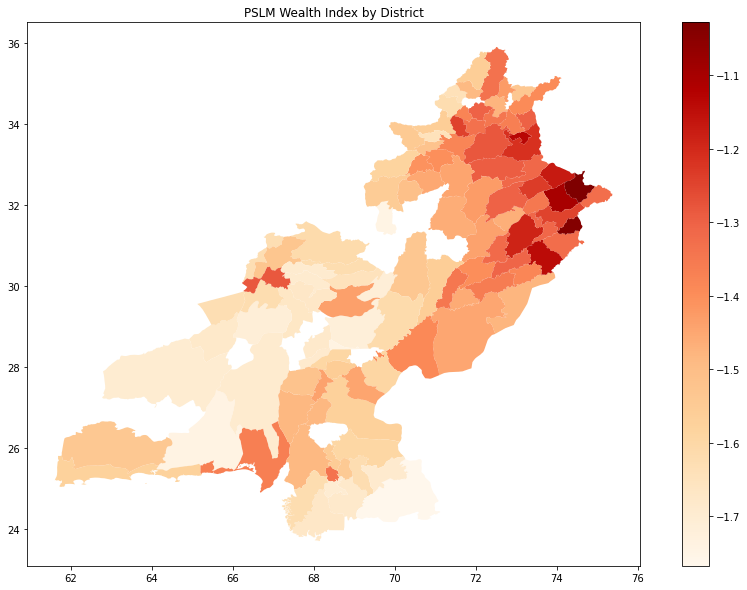

In [36]:
# Merge PSLM data with the shapefile
pslm_geo = districts.merge(pslm_district_wealth, left_on='ADM2_EN', right_on='District', how='left')

# Visualize the PSLM data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pslm_geo.plot(column='Wealth_Index1', ax=ax, legend=True, cmap='OrRd')
plt.title('PSLM Wealth Index by District')
plt.show()

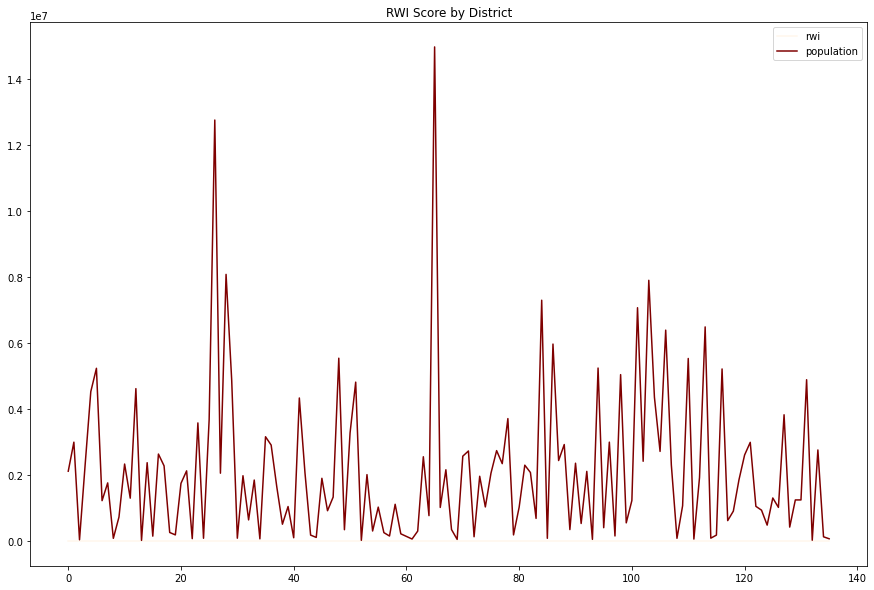

In [42]:
# For RWI data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
filtered_rwi_district_data.plot(column='rwi', ax=ax, legend=True, cmap='OrRd')
plt.title('RWI Score by District')
plt.show()